In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelC  heckpoint



In [6]:
train_path = 'DATASET/TRAIN'
test_path = 'DATASET/TEST'
IMG_BREDTH = 30
IMG_HEIGHT = 60
num_classes = 2


In [7]:
organic_count = len(os.listdir(os.path.join(train_path, 'O')))
recyclable_count = len(os.listdir(os.path.join(train_path, 'R')))
print(f"Class Distribution - Organic: {organic_count}, Recyclable: {recyclable_count}")


Class Distribution - Organic: 12565, Recyclable: 9999


In [30]:
train_batch = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_BREDTH),
    classes=['O', 'R'],
    batch_size=32
)

test_batch = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_BREDTH),
    classes=['O', 'R'],
    batch_size=32,
    shuffle=False
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Convert to NumPy array
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_batch.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.8978909669717469, 1: 1.1283128312831283}


In [31]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_BREDTH, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [32]:
model = cnn_model()
model.summary()


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 9, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 7, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     5,046,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,422,210 (20.68 MB)

 Trainable params: 5,422,210 (20.68 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
history = model.fit(
    train_batch,
    validation_data=test_batch,
    epochs=20,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 271s 384ms/step - accuracy: 0.7097 - loss: 0.5799 - val_accuracy: 0.8520 - val_loss: 0.4341
Epoch 2/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 124s 175ms/step - accuracy: 0.7636 - loss: 0.5223 - val_accuracy: 0.8201 - val_loss: 0.4094
Epoch 3/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 356s 505ms/step - accuracy: 0.7731 - loss: 0.5041 - val_accuracy: 0.8504 - val_loss: 0.3697
Epoch 4/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step - accuracy: 0.7821 - loss: 0.4959 - val_accuracy: 0.8691 - val_loss: 0.3535
Epoch 5/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.7709 - loss: 0.5013 - val_accuracy: 0.8536 - val_loss: 0.3634
Epoch 6/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 130s 183ms/step - accuracy: 0.7827 - loss: 0.4861 - val_accuracy: 0.8456 - val_loss: 0.3779
Epoch 7/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step - accuracy: 0.7893 - loss: 0.4784 - val_accuracy: 0.8563 - val_loss: 0.3595
Epoch 8/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 130s 185ms/step - accuracy: 0.7926 - lo

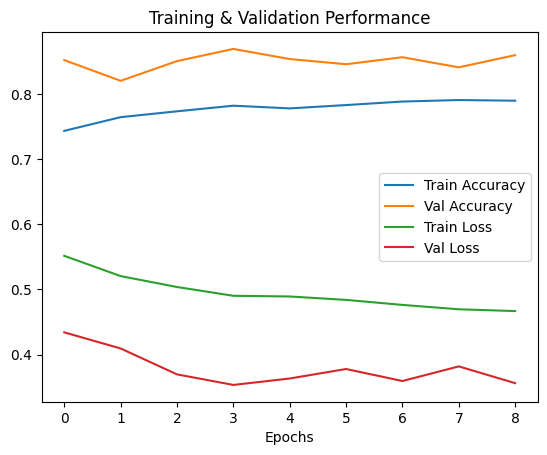

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Performance')
plt.xlabel('Epochs')
plt.show()

In [38]:
model = load_model('best_model.keras')
Y_pred = model.predict(test_batch)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_batch.classes, y_pred))

print('Classification Report')
target_names = ['Organic', 'Recyclable']
print(classification_report(test_batch.classes, y_pred, target_names=target_names))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Confusion Matrix
[[1308   93]
 [ 236  876]]
Classification Report
              precision    recall  f1-score   support

     Organic       0.85      0.93      0.89      1401
  Recyclable       0.90      0.79      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.86      0.87      2513
weighted avg       0.87      0.87      0.87      2513



In [43]:
print(train_batch.class_indices)  # Should print {'O': 0, 'R': 1}

{'O': 0, 'R': 1}


In [44]:
def predict_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB order
    img = cv2.resize(img, (IMG_BREDTH, IMG_HEIGHT))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    class_name = 'ORGANIC' if np.argmax(pred) == 0 else 'RECYCLABLE'
    print(f"Prediction: {class_name} (Probabilities: {pred})")

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


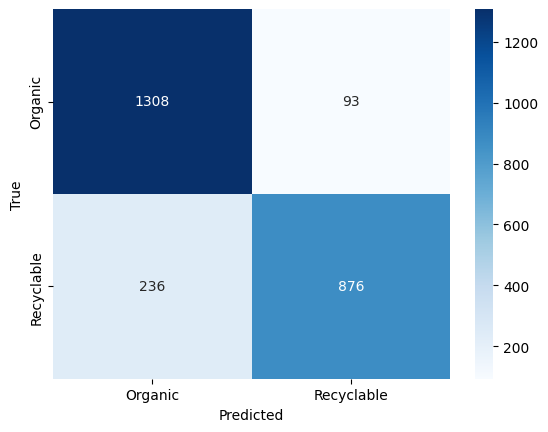

              precision    recall  f1-score   support

     Organic       0.85      0.93      0.89      1401
  Recyclable       0.90      0.79      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.86      0.87      2513
weighted avg       0.87      0.87      0.87      2513



In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_pred = model.predict(test_batch)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_batch.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Organic', 'Recyclable'], yticklabels=['Organic', 'Recyclable'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(test_batch.classes, y_pred, target_names=['Organic', 'Recyclable']))

In [47]:
print(predict_image("image.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: RECYCLABLE (Probabilities: [[0.14141625 0.85858375]])
None


In [48]:
print(predict_image("R_10018.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Prediction: ORGANIC (Probabilities: [[0.66340727 0.3365927 ]])
None


In [49]:
print(predict_image("O_13962.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction: ORGANIC (Probabilities: [[0.75019634 0.24980362]])
None


In [50]:
print(predict_image("O_12576.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction: ORGANIC (Probabilities: [[0.9558724  0.04412762]])
None


In [51]:
print(predict_image("R_10013.jpg"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: RECYCLABLE (Probabilities: [[0.14501265 0.8549873 ]])
None
